In [3]:
# Import necessary libraries
import emcee
import numpy as np
from multiprocessing import Pool, cpu_count
import copy
import time
from astropy.cosmology import FlatwCDM
import astropy.units as u
from astropy.table import Table

from matplotlib import pyplot as plt

from likelihoods_parallel import log_prior, log_probability, log_likelihood
from likelihoods_parallel import beta_double_source_plane, beta2theta_e_ratio
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

import corner
from chainconsumer import Chain
from chainconsumer import ChainConsumer
from chainconsumer import PlotConfig
from chainconsumer import ChainConfig
from chainconsumer.plotting import plot_contour
import os

In [11]:
# from hierarc.Likelihood.LensLikelihood.double_source_plane import (
#     beta_double_source_plane, beta2theta_e_ratio
# )

# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w_true = -1
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w": w_true}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define hierarchical model

kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "NONE",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.05


def draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma, sigma_beta, 
              down_sampling=1, with_noise=False):
    """
    draw the likelihood object of a double source plane lens
    
    :param down_sampling: downsampling factor, noise will be reduced by sqrt(down_sampling)
    """
    z_lens = np.random.uniform(low=0.1, high=1)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.normal(2, 1)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.normal(2, 1)
    if z1 > z2:
        z1, z2 = z2, z1
    #z_source1 = np.random.uniform(low=z_lens + 0.2, high=2.)
    #z_source2 = np.random.uniform(low=z_source1, high=3)
    beta = beta_double_source_plane(z_lens, z1, z2, cosmo_true)
    
    beta_e_list = []
    beta_e_mean = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl_mean, lambda_mst=lambda_mst_mean)
    for i in range(100):
        lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
        gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
        beta_e_ = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst)
        beta_e_list.append(beta_e_)
    beta_e_list = np.array(beta_e_list)
    beta_e_mean_ = np.mean(beta_e_list)
    beta_e_sigma = np.sqrt(np.std(beta_e_list)**2 + (sigma_beta * beta_e_mean)**2) / np.sqrt(down_sampling)
    if with_noise:
        beta_measured = beta_e_mean + np.random.normal(loc=0, scale=beta_e_sigma)
    else:
        beta_measured = beta_e_mean

    kwargs_likelihood = {
        "z_D": z_lens,
        "z_S1": z1,
        "z_S2": z2,
        "theta_E1_by_theta_E2": beta_measured,
        "theta_E1_by_theta_E2_err": beta_e_sigma,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood


# =====================================
# Settings for population of DSP
# =====================================

# number of double source plane lenses
num_dspl = 87

sigma_beta_dspl = 0.01  # relative precision on Einstein radius ratio


kwargs_dspl_lists_dict = {
    'z_D': [],
    'z_S1': [],
    'z_S2': [],
    'theta_E1_by_theta_E2': [],
    'theta_E1_by_theta_E2_err': [],
} 

for i in range(num_dspl):
    rslt = draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                     sigma_beta=sigma_beta_dspl,
                     with_noise=True,)

    for key in kwargs_dspl_lists_dict.keys():
        kwargs_dspl_lists_dict[key].append(rslt[key])

# make table with DSPL lenses
dspl_table = Table(kwargs_dspl_lists_dict)

In [12]:
def extract_observables(table, sigma_beta_E_true=None):
    """Extract observables from the table"""
    
    num_systems = len(table)
    
    # observed einstein radius ratios
    beta_E_obs_arr = table['theta_E1_by_theta_E2']

    if 'theta_E1_by_theta_E2_err' in table.colnames:
        beta_E_obs_err_arr = table['theta_E1_by_theta_E2_err']
    else:
        beta_E_obs_err_arr = beta_E_obs_arr * sigma_beta_E_true
    
    # redshifts
    if 'z_D' in table.colnames:
        z_lens_arr = table['z_D']
    elif 'z_D1' in table.colnames and 'z_D2' in table.colnames:
        z_lens_arr = table['z_D1'] + table['z_D2']
        z_lens_arr /= 2.0
    else:
        raise ValueError("Deflector redshift information not found in the table.")

    z1_arr = table['z_S1']
    z2_arr = table['z_S2']
    
    return beta_E_obs_arr, beta_E_obs_err_arr, z_lens_arr, z1_arr, z2_arr, sigma_beta_E_true, num_systems

def run_mcmc_analysis(z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr, 
                     ndim=4, nwalkers=400, nsteps=1000, nburn=200):
    """Run MCMC analysis on the data"""
    
    # Initialize Walkers [PARAMS: Omega_m, w, lambda_MST, gamma_pl]
    initial_guess_means = np.array([0.3, -1, 1, 2.0])
    initial_spreads = np.array([0.05, 0.2, 0.01, 0.01])
    pos_initial = np.zeros((nwalkers, ndim))
    
    for i in range(nwalkers):
        while True:
            p = initial_guess_means + initial_spreads * np.random.randn(ndim)
            if np.isfinite(log_prior(p)):
                if np.all(np.isfinite(log_likelihood(p, z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr))):
                    pos_initial[i,:] = p
                    break
    
    # Run MCMC
    sampler_args = (z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr)
    
    with Pool(processes=cpu_count()) as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            log_probability,
            args=sampler_args,
            pool=pool
        )

        print(f"Starting MCMC run: {nwalkers} walkers, {nsteps} steps, {cpu_count()} cores...")
        sampler.run_mcmc(pos_initial, nsteps, progress=True)
        print("MCMC run finished.")
    
    return sampler

In [17]:
# Define data files and their labels

# Tables must have the following columns:
# 'z_D1', 'z_D2', 'z_S1', 'z_S2', 
# 'theta_E1_by_theta_E2'

# Load the PDSPL table
pdspl_table = Table.read("../data/individual_pair_data_slsim_200.0_deg_red_deflectors.fits", format='fits')
pdspl_table = pdspl_table[
    (pdspl_table['rel_scatter_sigma_v_D'] < 0.01) &
    (pdspl_table['rel_scatter_z_D'] < 0.01)
]

# remove nans or invalid values from dspl_table
dspl_table = dspl_table[~np.isnan(dspl_table['theta_E1_by_theta_E2']) & 
                        ~np.isnan(dspl_table['theta_E1_by_theta_E2_err'])]


data_files = [
    {
        'data_table': pdspl_table,
        'name': "PDSPL",
        'color': 'blue',
        'sigma_beta_E_true': np.std(1 - (pdspl_table["theta_E1_by_theta_E2_virt"] + pdspl_table["theta_E1_virt_by_theta_E2"]) / (2 * pdspl_table["theta_E1_by_theta_E2"]))
    },
    {
        'data_table': dspl_table,
        'name': "DSPL",
        'color': 'red',
        'sigma_beta_E_true': sigma_beta_dspl
    },
]


=== Processing PDSPL ===
Relative uncertainty on observed beta_E: 0.0089
Number of data systems: 13568
Starting MCMC run: 400 walkers, 1000 steps, 20 cores...


100%|██████████| 1000/1000 [2:24:58<00:00,  8.70s/it] 


MCMC run finished.

=== Processing DSPL ===
Relative uncertainty on observed beta_E: 0.0100
Number of data systems: 87
Starting MCMC run: 400 walkers, 1000 steps, 20 cores...


  3%|▎         | 26/1000 [00:09<06:03,  2.68it/s]/home/paras/projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:43: RuntimeWarning: invalid value encountered in power
  theta_E_ratio = (beta_dsp * (2 - lambda_mst) - (1 - lambda_mst)) ** (1 / (gamma_pl - 1))
  3%|▎         | 28/1000 [00:10<06:54,  2.35it/s]/home/paras/projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:43: RuntimeWarning: invalid value encountered in power
  theta_E_ratio = (beta_dsp * (2 - lambda_mst) - (1 - lambda_mst)) ** (1 / (gamma_pl - 1))
  3%|▎         | 29/1000 [00:11<07:10,  2.26it/s]/home/paras/projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:43: RuntimeWarning: invalid value encountered in power
  theta_E_ratio = (beta_dsp * (2 - lambda_mst) - (1 - lambda_mst)) ** (1 / (gamma_pl - 1))
  3%|▎         | 30/1000 [00:11<07:18,  2.21it/s]/home/paras/projects/PDSPL/pdspl-analysis/notebooks/likelihoods_parallel.py:43: RuntimeWarning: invalid value encountered in power
  theta

MCMC run finished.

=== Generating Plots ===
Analysis complete!


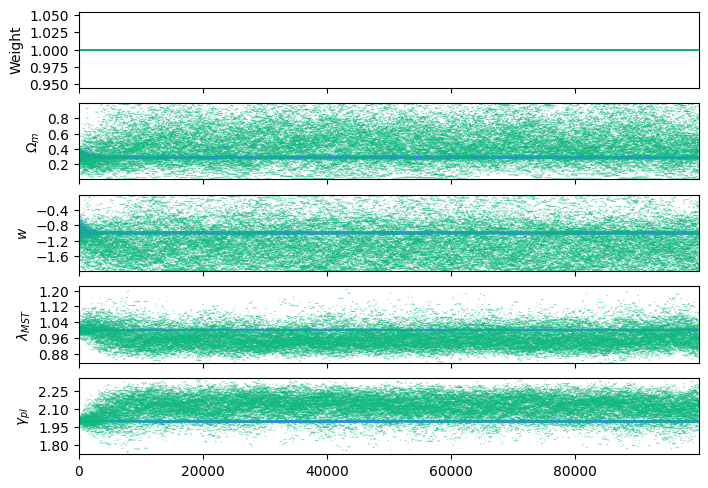

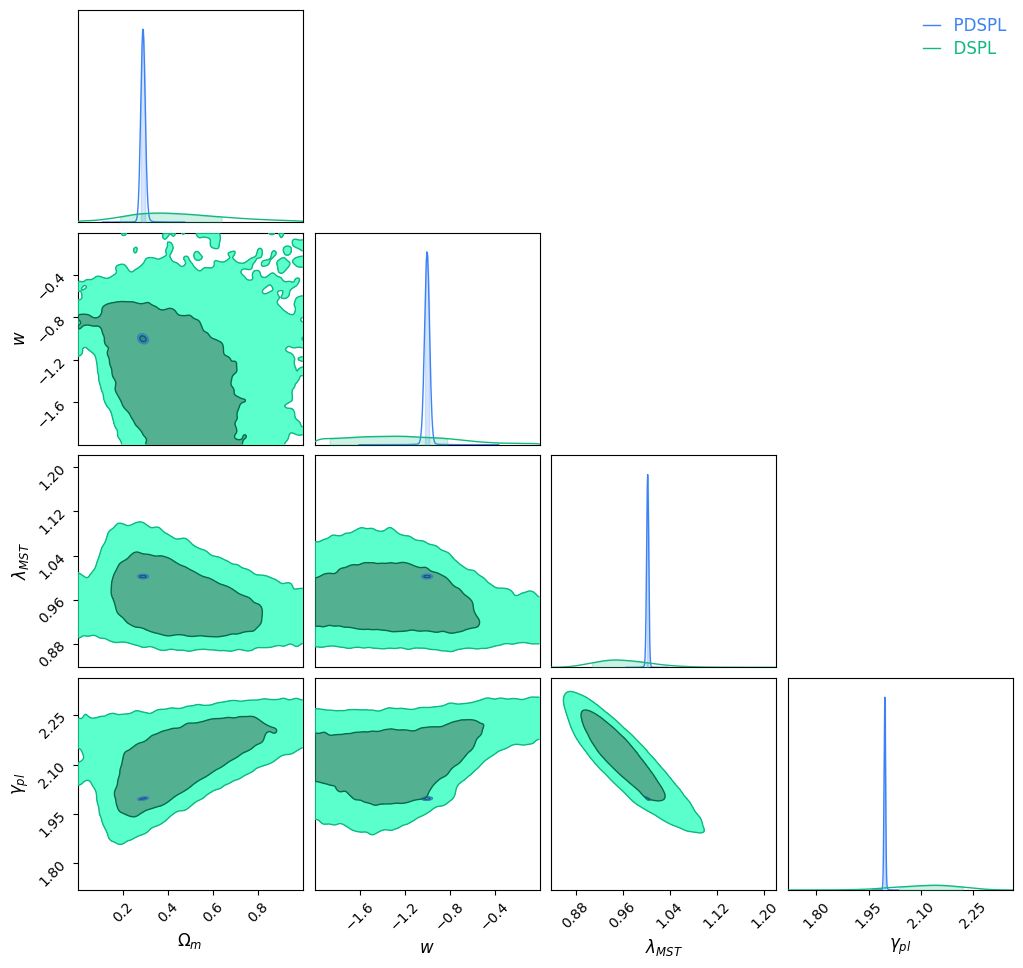

In [18]:
# True cosmological parameters
Om_true = 0.3
w_true = -1.0
H0_true = 70.0 # kept fixed
lambda_MST_true = 1.0
gamma_pl_true = 2.0
latex_labels = [r"$\Omega_m$", r"$w$", r"$\lambda_{MST}$", r"$\gamma_{pl}$"]

# MCMC Parameters
ndim = 4
nwalkers = 400
nsteps = 1000
nburn = 200

# Initialize ChainConsumer
cc = ChainConsumer()

# Process each dataset
for data_info in data_files:
    data_table = data_info['data_table']
    name = data_info['name']
    sigma_beta_E_true = data_info.get('sigma_beta_E_true', None)
    
    print(f"\n=== Processing {name} ===")
    
    # Load and process data
    beta_E_obs_arr, beta_E_obs_err_arr, z_lens_arr, z1_arr, z2_arr, sigma_beta_E_true, num_systems = extract_observables(data_table, sigma_beta_E_true)
    
    print(f"Relative uncertainty on observed beta_E: {sigma_beta_E_true:.4f}")
    print(f"Number of data systems: {num_systems}")
    
    # Run MCMC analysis
    sampler = run_mcmc_analysis(z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr,
                               ndim, nwalkers, nsteps, nburn)
    
    # Create chain for ChainConsumer
    chain = Chain.from_emcee(
        sampler,
        latex_labels,
        name=name,
    )
    
    # Add chain to ChainConsumer
    cc.add_chain(chain)

# Add truth values (uncomment if needed)
# cc.add_truth([Om_true, w_true, lambda_MST_true, gamma_pl_true])

# Plot the results
print("\n=== Generating Plots ===")

# Plot walker traces
fig = cc.plotter.plot_walks()
fig.show()

# Plot corner plot with all chains
fig = cc.plotter.plot()
fig.show()

print("Analysis complete!")

In [19]:
# external priors

sigma_lambda_prior = 0.01
sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    lambda_int = chain.samples['$\\lambda_{MST}$']
    om = chain.samples['$\\Omega_m$']
    gamma_pl = chain.samples['$\\gamma_{pl}$']
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    weights = np.exp(weights_gamma + weights_lambda + weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + deflector prior"
    return chain_weights

dspl_chain = cc.get_chain(cc.get_names()[0])  # Get the first chain (DSPL)
pdspl_chain = cc.get_chain(cc.get_names()[1])  # Get the second chain (PDSPL)
dspl_chain_prior = add_prior_to_chain(dspl_chain)
pdspl_chain_prior = add_prior_to_chain(pdspl_chain)

# Add chains with priors to ChainConsumer
cc.add_chain(dspl_chain_prior)
cc.add_chain(pdspl_chain_prior)

# Plot the results with priors
print("\n=== Generating Plots with Priors ===")


=== Generating Plots with Priors ===


Parameter $\Omega_m$ in chain PDSPL + deflector prior is not constrained
Parameter $w$ in chain PDSPL + deflector prior is not constrained
Parameter $w$ in chain DSPL + deflector prior is not constrained
Parameter $\lambda_{MST}$ in chain PDSPL + deflector prior is not constrained
Parameter $\gamma_{pl}$ in chain PDSPL + deflector prior is not constrained


Analysis complete!


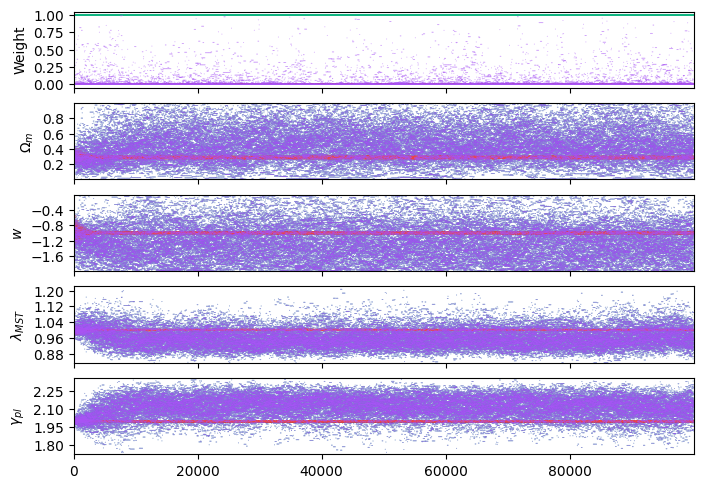

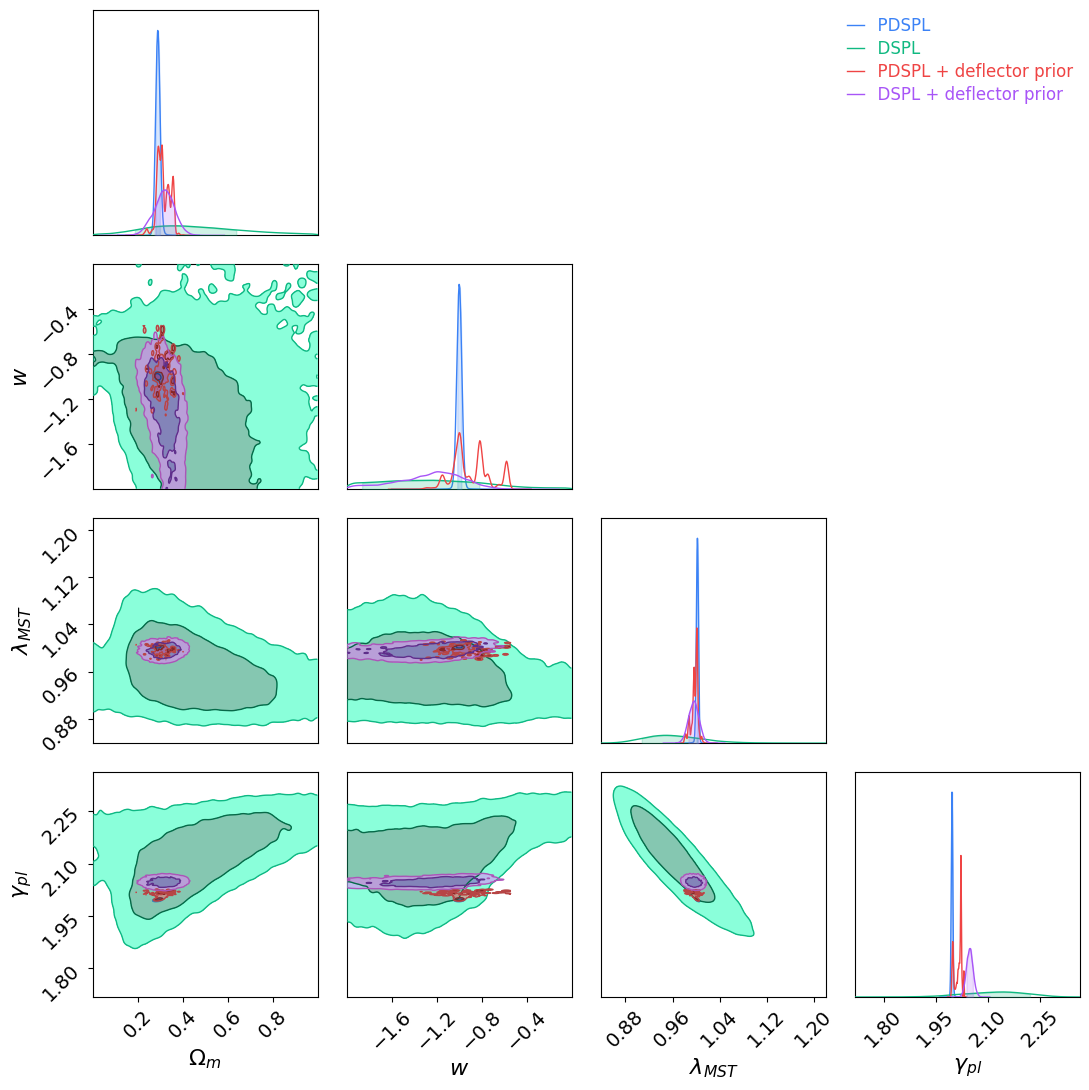

In [20]:
# Plot walker traces
fig = cc.plotter.plot_walks()
fig.show()

# Plot corner plot with all chains
fig = cc.plotter.plot()
fig.show()

# Increase label and tick sizes
for ax in fig.get_axes():
    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

fig.tight_layout()

print("Analysis complete!")

# save the figure
fig.savefig("../figures/DSPL_PDSPL_forecast.pdf", dpi=300, bbox_inches='tight')

In [32]:
# print the results
print("\n=== Results ===")

number_of_systems = {
    "PDSPL": len(pdspl_table),
    "DSPL": len(dspl_table),
    "PDSPL + deflector prior": len(pdspl_table),
    "DSPL + deflector prior": len(dspl_table),
}

for name in cc.get_names():
    chain = cc.get_chain(name)
    print(f"\nChain: {chain.name}" + f"({number_of_systems[name]} systems)")
    print(f"Omega_m: {np.mean(chain.samples['$\\Omega_m$']):.4f} ± {np.std(chain.samples['$\\Omega_m$']):.4f}")
    print(f"w: {np.mean(chain.samples['$w$']):.4f} ± {np.std(chain.samples['$w$']):.4f}")
    print(f"lambda_MST: {np.mean(chain.samples['$\\lambda_{MST}$']):.4f} ± {np.std(chain.samples['$\\lambda_{MST}$']):.4f}")
    print(f"gamma_pl: {np.mean(chain.samples['$\\gamma_{pl}$']):.4f} ± {np.std(chain.samples['$\\gamma_{pl}$']):.4f}")


=== Results ===

Chain: PDSPL(13568 systems)
Omega_m: 0.2896 ± 0.0093
w: -1.0008 ± 0.0197
lambda_MST: 1.0023 ± 0.0017
gamma_pl: 1.9966 ± 0.0021

Chain: DSPL(87 systems)
Omega_m: 0.4538 ± 0.2146
w: -1.2272 ± 0.4588
lambda_MST: 0.9634 ± 0.0483
gamma_pl: 2.1161 ± 0.0894

Chain: PDSPL + deflector prior(13568 systems)
Omega_m: 0.2896 ± 0.0093
w: -1.0008 ± 0.0197
lambda_MST: 1.0023 ± 0.0017
gamma_pl: 1.9966 ± 0.0021

Chain: DSPL + deflector prior(87 systems)
Omega_m: 0.4538 ± 0.2146
w: -1.2272 ± 0.4588
lambda_MST: 0.9634 ± 0.0483
gamma_pl: 2.1161 ± 0.0894


In [68]:
cc.remove_chain('DSPL + deflector prior')
cc.remove_chain('PDSPL + deflector prior')